# Multi-layer Perceptron (MLP)

- **Training set**: LO_SARD102
- **Test/Validation set:** JTT
- **Features**: word2vec average
- **Class imbalance processing**: Weighted classes

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/home/scheuererra68323/venv37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Load labeled dataset

In [2]:
dataset = pd.read_hdf("/mnt/md0/user/scheuererra68323/LO_SARD102/LO_SARD102_word2vec.h5")
testset = pd.read_hdf("/mnt/md0/user/scheuererra68323/JTT/JTT_word2vec.h5")
print(dataset.shape)
print(dataset.is_vulnerable.value_counts())
print()
print(testset.shape)
print(testset.is_vulnerable.value_counts())

(292724, 2)
0.0    269721
1.0     23003
Name: is_vulnerable, dtype: int64

(24999, 2)
0.0    24171
1.0      828
Name: is_vulnerable, dtype: int64


## Prepare train and test datasets

In [4]:
# randomize both datasets
dataset = dataset.sample(frac=1).reset_index(drop=True)
testset = testset.sample(frac=1).reset_index(drop=True)

X_train, X_val, Y_train, Y_val = train_test_split(
    dataset.word2vec_avg,
    dataset.is_vulnerable,
    test_size=0.2,
    stratify=dataset.is_vulnerable,
    random_state=0
)
X_test, Y_test = testset.word2vec_avg, testset.is_vulnerable

X_train = numpy.stack(X_train, axis=0)
Y_train = numpy.stack(Y_train, axis=0)
X_val = numpy.stack(X_val, axis=0)
Y_val = numpy.stack(Y_val, axis=0)
X_test = numpy.stack(X_test, axis=0)
Y_test = numpy.stack(Y_test, axis=0)

# prepare class weights
weight_0 = ( 1 / Counter(Y_train)[0] ) * Y_train.shape[0] / 2.0
weight_1 = ( 1 / Counter(Y_train)[1] ) * Y_train.shape[0] / 2.0

print("Training Set:")
print(f"{len(X_train)} total")
print(Counter(Y_train))
print()      
print("Validation Set:")
print(f"{len(X_val)} total")
print(Counter(Y_val))
print()      
print("Test Set:")
print(f"{len(X_test)} total")
print(Counter(Y_test))
print()
print("Class weights:")
print((weight_0, weight_1))

Training Set:
234179 total
Counter({0.0: 215777, 1.0: 18402})

Validation Set:
58545 total
Counter({0.0: 53944, 1.0: 4601})

Test Set:
24999 total
Counter({0.0: 24171, 1.0: 828})

Class weights:
(0.5426412453597927, 6.362868166503641)


## Model definition & Training

In [21]:
init_mode = 'glorot_uniform'
model = keras.Sequential(
    [
        layers.Dense(64,
                     input_dim=100,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),


        layers.Dropout(0.1),

        layers.Dense(64,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),

        layers.Dense(64,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),


        layers.Dense(1, 
                     kernel_initializer=init_mode, 
                     activation=tf.nn.sigmoid),
    ]
)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.03, momentum=0.9, decay=0.001),
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=X_train.shape[0],
                    epochs=100,
                    verbose=True,
                    validation_data=(X_val, Y_val),
                    class_weight = {0: weight_0, 1: weight_1})

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0
_________________________________________________________________
Train on 234179 samples, validate on 58545 samples
Epoch 1/100
234179/234179 [==============================] - 1s 4

Epoch 48/100
234179/234179 [==============================] - 0s 1us/sample - loss: 0.2525 - accuracy: 0.8856 - val_loss: 0.2364 - val_accuracy: 0.8918
Epoch 49/100
234179/234179 [==============================] - 0s 1us/sample - loss: 0.2499 - accuracy: 0.8879 - val_loss: 0.2340 - val_accuracy: 0.8957
Epoch 50/100
234179/234179 [==============================] - 0s 1us/sample - loss: 0.2480 - accuracy: 0.8913 - val_loss: 0.2316 - val_accuracy: 0.9025
Epoch 51/100
234179/234179 [==============================] - 0s 1us/sample - loss: 0.2455 - accuracy: 0.8943 - val_loss: 0.2291 - val_accuracy: 0.9023
Epoch 52/100
234179/234179 [==============================] - 0s 1us/sample - loss: 0.2424 - accuracy: 0.8974 - val_loss: 0.2268 - val_accuracy: 0.9043
Epoch 53/100
234179/234179 [==============================] - 0s 1us/sample - loss: 0.2396 - accuracy: 0.8983 - val_loss: 0.2247 - val_accuracy: 0.9054
Epoch 54/100
234179/234179 [==============================] - 0s 1us/sample - loss: 0.23

## Evaluation

              precision    recall  f1-score   support

         0.0       0.98      0.02      0.04     24171
         1.0       0.03      0.99      0.06       828

    accuracy                           0.05     24999
   macro avg       0.51      0.51      0.05     24999
weighted avg       0.95      0.05      0.04     24999

Confusion matrix:
[[  537 23634]
 [   10   818]]

Confusion matrix (Percentages):
[[2.148e+00 9.454e+01]
 [4.000e-02 3.272e+00]]

Metrics:
Sensitivity (TPR): 0.987923
Specifity (TNR):   0.022217

FPR: 0.977783
FNR: 0.012077

Balanced accuracy: 0.505070

Test loss:	1.494657
Test accuracy:	0.054202


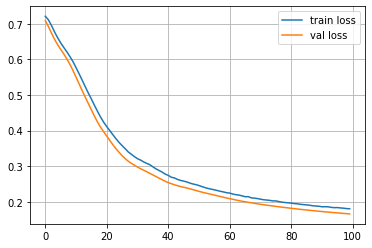

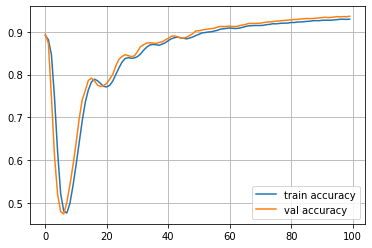

In [22]:
Y_pred = numpy.round(model.predict(X_test))

print(classification_report(Y_test, Y_pred))
print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
print()
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:\t{:.6f}'.format(score[0]))
print('Test accuracy:\t{:.6f}'.format(score[1]))

plot_loss(history)
plot_accuracy(history)

In [23]:
model.save('testJTT_MLP_word2vec_weightedClasses')

INFO:tensorflow:Assets written to: testJTT_MLP_word2vec_weightedClasses/assets


## Discussion